In [1]:
# ! pip install opencv-python pycocotools matplotlib onnxruntime onnx
# ! pip install git+https://github.com/facebookresearch/segment-anything.git
# ! pip install diffusers transformers==4.27.0 accelerate scipy safetensors
# ! pip install jsonlines ftfy

In [2]:
from PIL import Image
import pickle,cv2,copy,math,os,sys
import torch
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from clip_wrapper import Taiyi_CLIP,get_taiyi_image_process,extract_image_func,extract_image_func_PIL,extract_text_func
from util import trans_to_square,trans_to_square_inputImage,expand_mask_v2,write_segment_mask,get_mask

In [3]:
# load segmentanything model
from segmentanything_wrapper import mask_generator
# load stablediffusion_inpainting_pipeline
from stablediffusion_wrapper import pipe as sd_pipe
# load clip and the guide function
from clip_wrapper import clip_guide_func
clip_guide=clip_guide_func()

==> use segment anything:vit_l
loading stable diffusion


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Info:Load StableDiffusionInpaintPipeline form ../StableDiffusion/stable-diffusion-inpainting


In [4]:
# define input
image_path_='image/51164.jpg'
prompt_text='长椅'# the objert you want to edit
source_prompt=f'完整的{prompt_text}' # prompt for clip-guided mask
target_prompt='leather style bench'  # prompt for what you want to generate, it should be a englise input because we use runwayml/stable-diffusion-inpainting(https://huggingface.co/runwayml/stable-diffusion-inpainting/discussions) in this demo

segment result


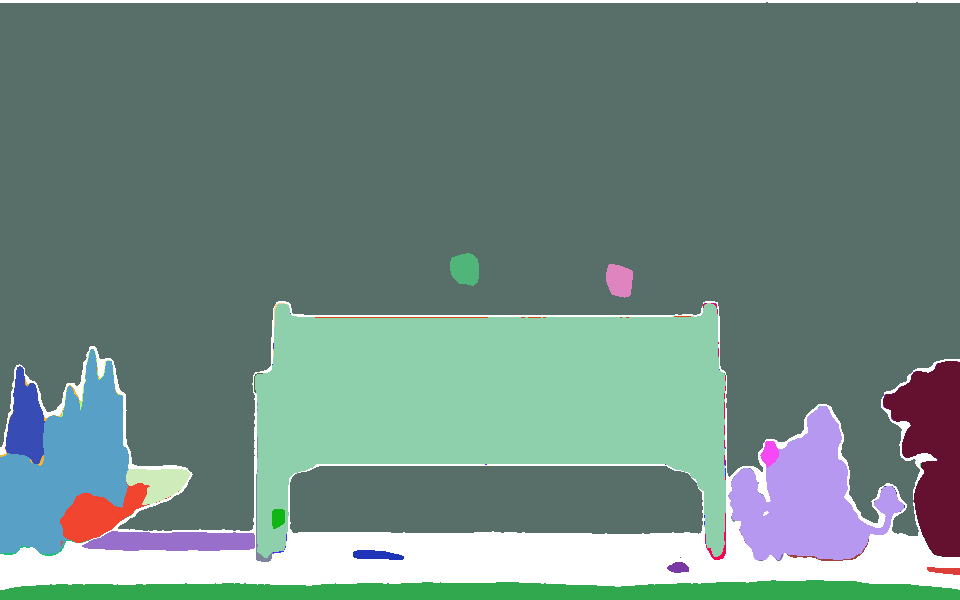

In [5]:
# get segments from SAM
raw_image = cv2.imread(image_path_)
all_segments = mask_generator.generate(raw_image)
seg_mean_jpg=write_segment_mask(all_segments,image_path_)
print('segment result')
seg_mean_jpg.show()

best image:


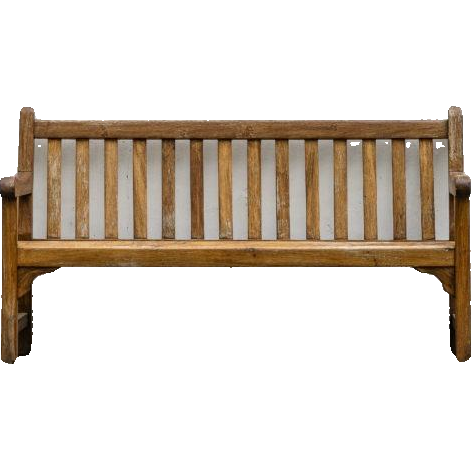

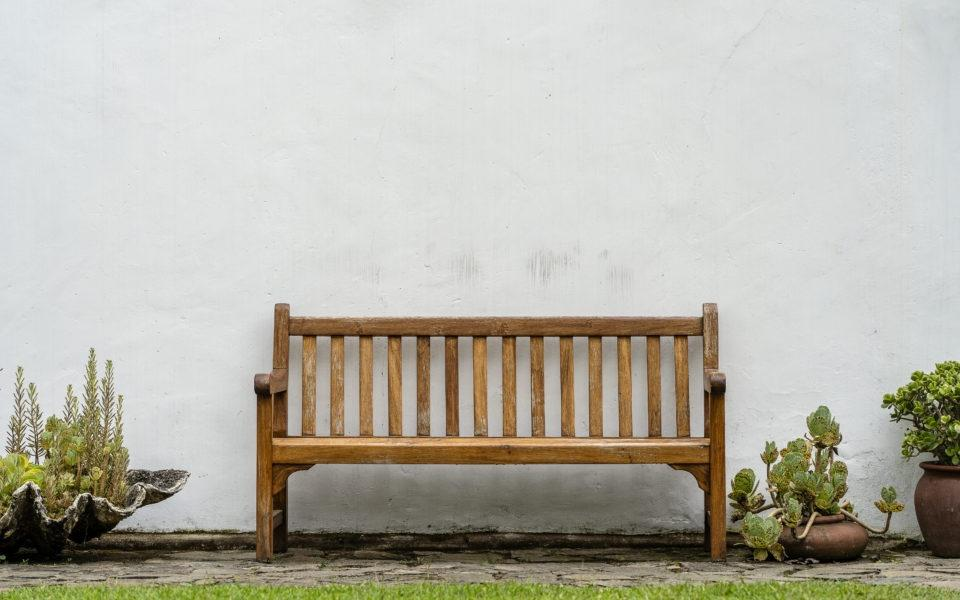

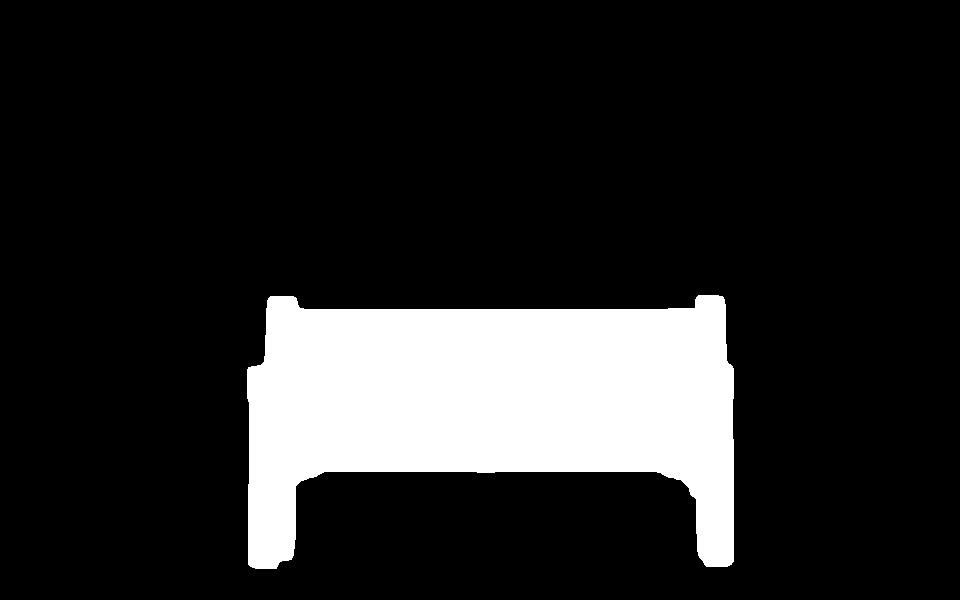

In [6]:
# get clip-guided mask by clip
all_sub_image=clip_guide(all_segments,source_prompt,raw_image)
best_sub_img,sim_,chose_index=all_sub_image[0]
print('best image:')
best_sub_img.show()
image_path_,all_segments[chose_index]['segmentation']
maskit_raw=all_segments[chose_index]['segmentation']
mask_array=expand_mask_v2(maskit_raw,expand_length=8) #expand the mask area a little
mask_img_=get_mask(mask_array,image_path_)
meta_image=Image.open(image_path_).convert('RGB')
meta_image.show()
mask_img_.show()

  0%|          | 0/50 [00:00<?, ?it/s]

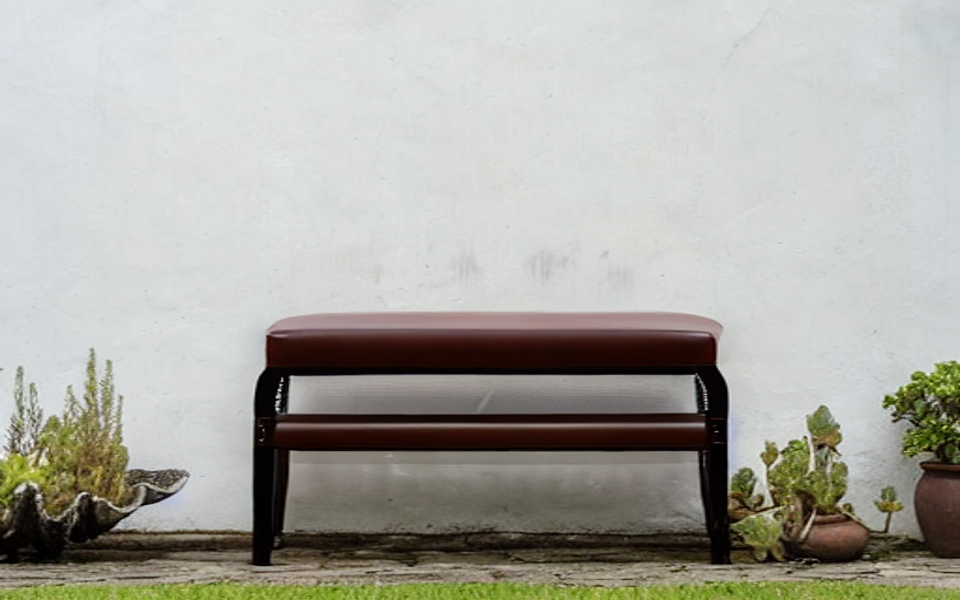

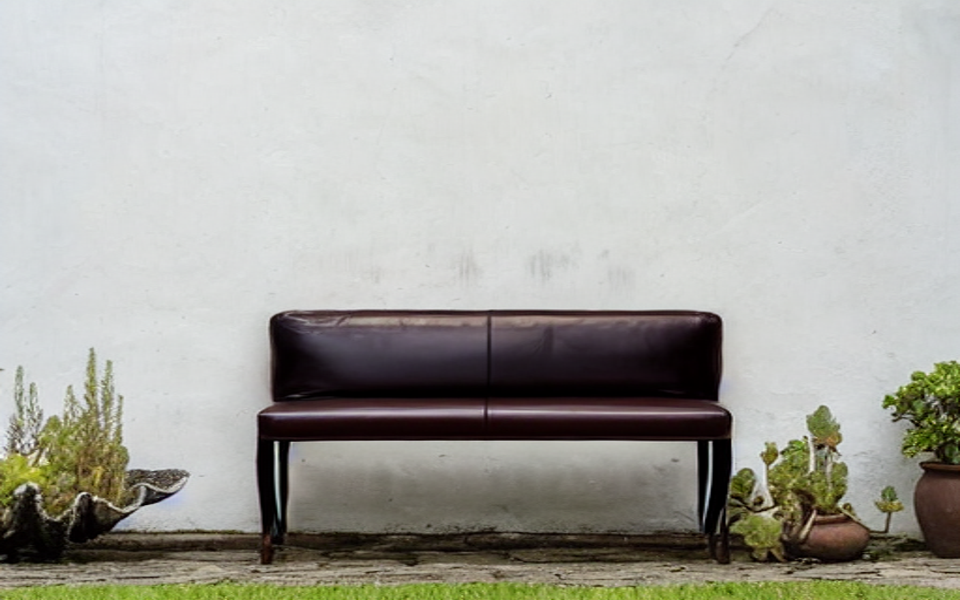

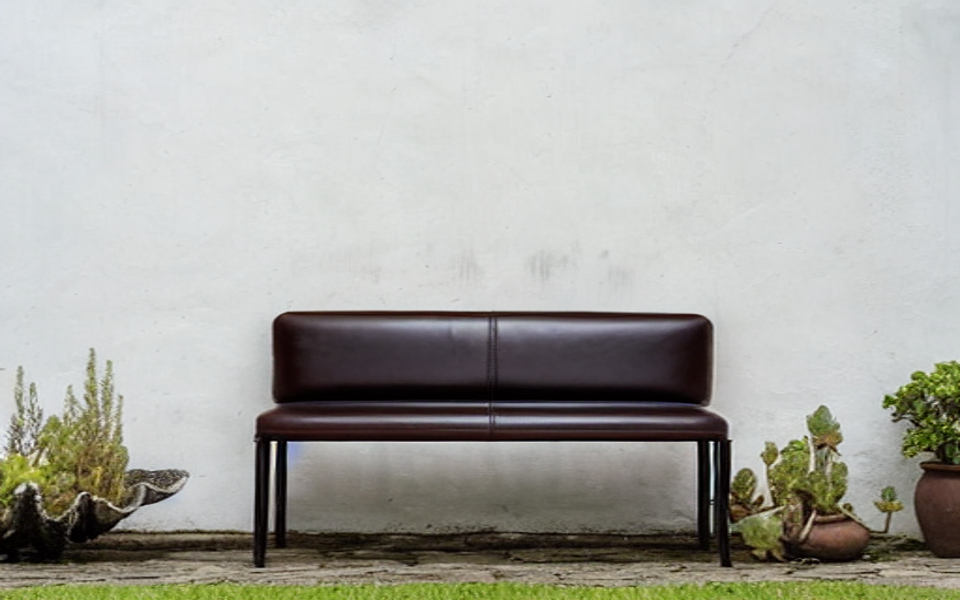

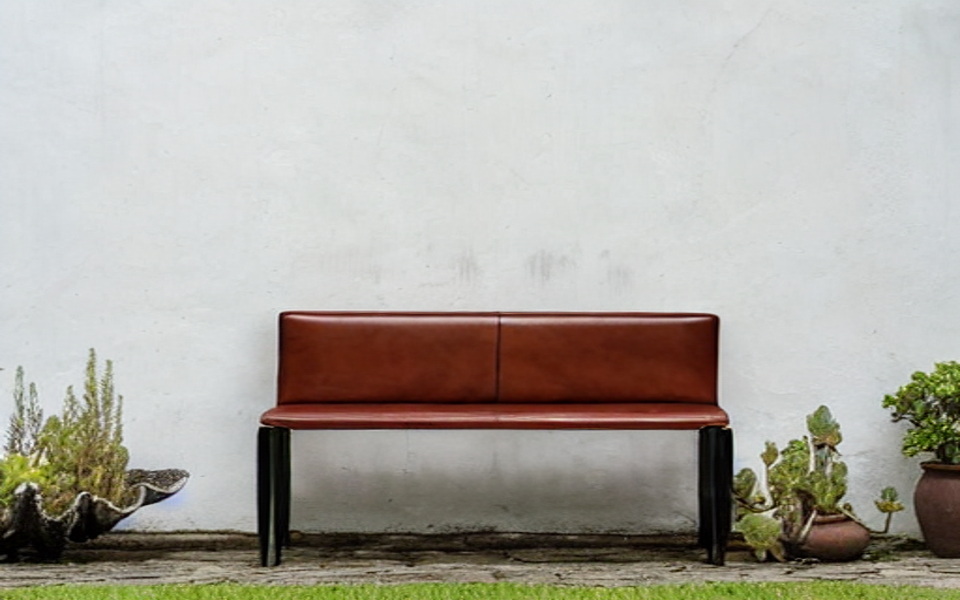

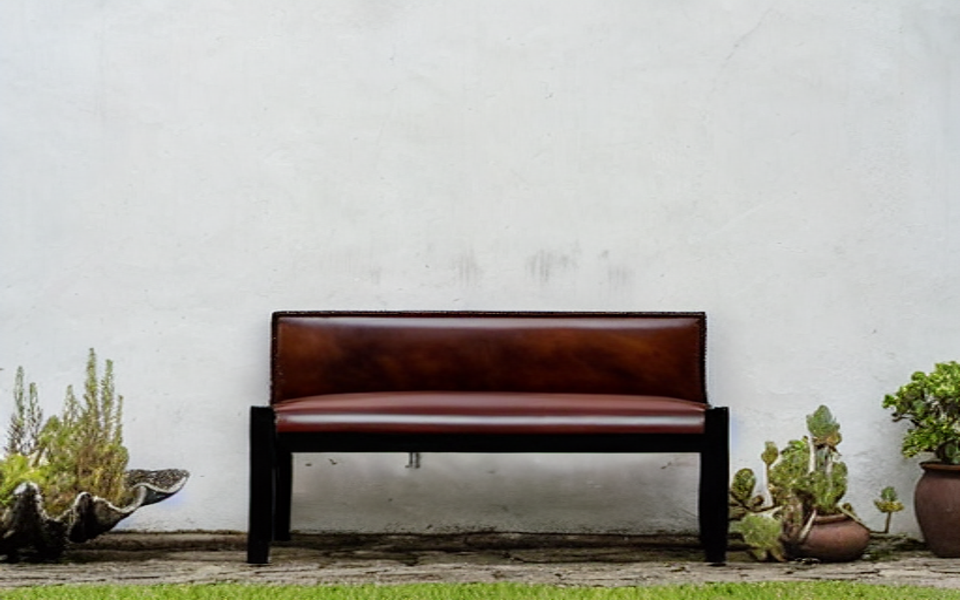

In [7]:
# Edit the image according clip-guided mask and target_prompt,by stable diffusion 
row_shape=meta_image.size
image = sd_pipe(prompt=target_prompt, 
             image=meta_image.convert('RGB').resize((512, 512)), 
             mask_image=mask_img_.convert('RGB').resize((512, 512)),
             num_images_per_prompt=5,
             #guidance_scale=10,
             # num_inference_steps=50,
            )
for img_ in image.images:
    img_.resize(row_shape).show()